In [80]:
# Dependencies 
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from scipy.stats import linregress
from sklearn import linear_model
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from census import Census
import seaborn as sns
import tkinter as tk 
import pandas as pd
%matplotlib inline
import numpy as np
import requests
import gmaps
import time
import json
import re

# Census & gmaps API Keys

from config import gkey
gmaps.configure(api_key=gkey)

# DATA CLEANING STEPS

### First dataset on Zillow Home Value Index, Median Sale Price, Monthly Home Sales, Foreclosure Resales
#### Source Zillow

In [51]:
# ZHVI All Homes (SFR, Condo/Co-op) Time Series ($) (by ZIP code)
csv_home_values = "Resources/Zip_Zhvi_AllHomes.csv"

# Median Sale Price - Seasonally Adjusted ($) (by ZIP code)
csv_home_sales = "Resources/Sale_Prices_Zip.csv"

# Monthly Home Sales (Number, Raw) (by ZIP code)
csv_number_sales = "Resources/Sale_Counts_Zip.csv"

# Foreclosure Resales (%) (by ZIP code)
csv_foreclosure_resales = "Resources/SalesPrevForeclosed_Share_Zip.csv"

home_values = pd.read_csv(csv_home_values, encoding="ISO-8859-1")
home_sales = pd.read_csv(csv_home_sales, encoding="ISO-8859-1")
number_sales = pd.read_csv(csv_number_sales, encoding="ISO-8859-1")
foreclosure_resales = pd.read_csv(csv_foreclosure_resales, encoding="ISO-8859-1")

# Suffixes:
# ZVHI = Zillow Home Value Index ($)
# MSR = Median Sales Price - Seasonally Adjusted ($)
# NS = Number of Sales
# FR = Foreclosure Resales (%)

In [52]:
# Python Dictionary to translate US States to Two letter codes
# Dictionary obtained from rogerallen (https://gist.github.com/rogerallen/1583593)
us_state_abbrev = {
    'Alabama': 'AL','Alaska': 'AK','Arizona': 'AZ','Arkansas': 'AR','California': 'CA',
    'Colorado': 'CO','Connecticut': 'CT','Delaware': 'DE','District of Columbia': 'DC',
    'Florida': 'FL','Georgia': 'GA','Hawaii': 'HI','Idaho': 'ID','Illinois': 'IL',
    'Indiana': 'IN','Iowa': 'IA','Kansas': 'KS','Kentucky': 'KY','Louisiana': 'LA',
    'Maine': 'ME','Maryland': 'MD','Massachusetts': 'MA','Michigan': 'MI','Minnesota': 'MN',
    'Mississippi': 'MS','Missouri': 'MO','Montana': 'MT','Nebraska': 'NE','Nevada': 'NV',
    'New Hampshire': 'NH','New Jersey': 'NJ','New Mexico': 'NM','New York': 'NY',
    'North Carolina': 'NC','North Dakota': 'ND','Northern Mariana Islands':'MP','Ohio': 'OH',
    'Oklahoma': 'OK','Oregon': 'OR','Palau': 'PW','Pennsylvania': 'PA','Puerto Rico': 'PR',
    'Rhode Island': 'RI','South Carolina': 'SC','South Dakota': 'SD','Tennessee': 'TN',
    'Texas': 'TX','Utah': 'UT','Vermont': 'VT','Virgin Islands': 'VI','Virginia': 'VA',
    'Washington': 'WA','West Virginia': 'WV','Wisconsin': 'WI','Wyoming': 'WY',
}

# Rename StateName columns
home_values = home_values.rename(columns={"RegionName":"ZIP Code",
                                          "2008-01":"2008-01_ZHVI",
                                          "2008-02":"2008-02_ZHVI"})
home_sales = home_sales.rename(columns={"RegionName":"ZIP Code",
                                        "StateName":"State"})
number_sales = number_sales.rename(columns={"RegionName":"ZIP Code",
                                            "StateName":"State",
                                            "seasAdj":"seasAdj_NS"})
foreclosure_resales = foreclosure_resales.rename(columns={"RegionName":"ZIP Code",
                                                          "StateName":"State"})

# Translate states into two letter codes for each file and handle errors
try:
    for index, row in home_sales.iterrows():
        state = home_sales.loc[index, "State"]
        abbr = us_state_abbrev[state]
        home_sales.loc[index, "State"] = abbr

    for index, row in number_sales.iterrows():
        state = number_sales.loc[index, "State"]
        abbr = us_state_abbrev[state]
        number_sales.loc[index, "State"] = abbr

    for index, row in foreclosure_resales.iterrows():
        state = foreclosure_resales.loc[index, "State"]
        abbr = us_state_abbrev[state]
        foreclosure_resales.loc[index, "State"] = abbr
except:
    pass

home_values.head()

,RegionID,ZIP Code,City,State,Metro,CountyName,SizeRank,2008-01_ZHVI,2008-02_ZHVI,2008-03,...,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11
0,84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,1,NaN,NaN,NaN,...,4.846133e+05,4.844847e+05,4.856167e+05,4.865600e+05,4.858847e+05,4.849017e+05,4.823117e+05,4.800917e+05,4.787937e+05,4.785953e+05
1,61637,10023,New York,NY,New York-Newark-Jersey City,New York County,2,NaN,NaN,NaN,...,1.192562e+06,1.184811e+06,1.182110e+06,1.185962e+06,1.188839e+06,1.181644e+06,1.163996e+06,1.148232e+06,1.148030e+06,1.163213e+06
2,91982,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,3,269106.0,268326.0,267699.333333,...,3.352377e+05,3.350893e+05,3.339180e+05,3.331563e+05,3.325493e+05,3.327513e+05,3.328630e+05,3.339837e+05,3.346290e+05,3.352343e+05
3,84616,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,4,NaN,NaN,NaN,...,6.303370e+05,6.304280e+05,6.328107e+05,6.339393e+05,6.326857e+05,6.306867e+05,6.281890e+05,6.261287e+05,6.251030e+05,6.240497e+05
4,91940,77449,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,5,128064.0,127776.0,127537.666667,...,1.814760e+05,1.818737e+05,1.817140e+05,1.818840e+05,1.823700e+05,1.831330e+05,1.839323e+05,1.843723e+05,1.851663e+05,1.863170e+05


In [53]:
# Merge the home_values, home_sales, number_sales and foreclosure_resales
merge1 = pd.merge(home_values, home_sales, on=["ZIP Code","State","RegionID"], how="outer", suffixes=("_ZHVI", "_MSR"))
merge2 = pd.merge(number_sales, foreclosure_resales, on=["ZIP Code","State","RegionID"], how="outer", suffixes=("_NS", "_FR"))
main_data = pd.merge(merge1, merge2, on=["ZIP Code","State","RegionID"], how="outer")
main_data.head()

,RegionID,ZIP Code,City,State,Metro,CountyName,SizeRank_ZHVI,2008-01_ZHVI,2008-02_ZHVI,2008-03_ZHVI,...,2019-02_FR,2019-03_FR,2019-04_FR,2019-05_FR,2019-06_FR,2019-07_FR,2019-08_FR,2019-09_FR,2019-10_FR,2019-11_FR
0,84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,1.0,NaN,NaN,NaN,...,0.0000,0.0092,0.0064,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,61637,10023,New York,NY,New York-Newark-Jersey City,New York County,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,91982,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,3.0,269106.0,268326.0,267699.333333,...,0.0058,0.0083,0.0072,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,84616,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,4.0,NaN,NaN,NaN,...,0.0000,0.0000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,91940,77449,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,5.0,128064.0,127776.0,127537.666667,...,0.0000,0.0123,0.0123,0.0181,0.006,NaN,NaN,NaN,NaN,NaN


In [54]:
# Function to get mean of the columns from minimum month and year to maximum month and year with different suffixes
# Used regular expressions
def findavg(data,year,suffix):
    x = []
    for i in data.columns:
        # Find all words matching the year and suffix and append to x
        y = (re.findall(f'^{year}-([0-9][0-9])_{suffix}',i))
        [x.append(int(i)) for i in y]
    min_col = data.columns.get_loc(f"{year}-{min(x):02d}_{suffix}")
    max_col = data.columns.get_loc(f"{year}-{max(x):02d}_{suffix}")
    data[f"{year}_Avg_{suffix}"] = data.iloc[:,min_col:max_col+1].mean(axis=1)
    return data[f"{year}_Avg_{suffix}"]

In [55]:
# Grabbed the 'RegionID', 'ZIP Code', 'City', 'State', 'CountyName' columns from main_data
new_main_data = main_data[['RegionID', 'ZIP Code', 'City', 'State', 'CountyName']]
new_main_data.head()

,RegionID,ZIP Code,City,State,CountyName
0,84654,60657,Chicago,IL,Cook County
1,61637,10023,New York,NY,New York County
2,91982,77494,Katy,TX,Harris County
3,84616,60614,Chicago,IL,Cook County
4,91940,77449,Katy,TX,Harris County


In [56]:
#Join all suffixes across different years to new_main_data
years = [i for i in range(2008,2020,1)]
suffixes = ["ZHVI","MSR","NS","FR"]

for year in years:
    for suffix in suffixes:
        new_main_data = new_main_data.join(findavg(main_data,year,suffix))
new_main_data.head()

,RegionID,ZIP Code,City,State,CountyName,2008_Avg_ZHVI,2008_Avg_MSR,2008_Avg_NS,2008_Avg_FR,2009_Avg_ZHVI,...,2017_Avg_NS,2017_Avg_FR,2018_Avg_ZHVI,2018_Avg_MSR,2018_Avg_NS,2018_Avg_FR,2019_Avg_ZHVI,2019_Avg_MSR,2019_Avg_NS,2019_Avg_FR
0,84654,60657,Chicago,IL,Cook County,479900.645833,376410.0,146.9,0.00000,466041.694444,...,213.000000,0.004208,4.886200e+05,3.704417e+05,179.750000,0.005367,4.835098e+05,4.097091e+05,131.090909,0.006700
1,61637,10023,New York,NY,New York County,NaN,NaN,NaN,NaN,833515.733333,...,75.333333,NaN,1.216848e+06,1.115458e+06,77.500000,NaN,1.176796e+06,1.146527e+06,71.909091,NaN
2,91982,77494,Katy,TX,Harris County,267059.388889,243020.0,79.2,0.03512,267583.416667,...,257.666667,0.002967,3.329190e+05,3.316750e+05,253.916667,0.001367,3.340930e+05,3.250500e+05,242.400000,0.007025
3,84616,60614,Chicago,IL,Cook County,606633.729167,NaN,NaN,NaN,594972.111111,...,215.400000,0.002430,6.361214e+05,4.334167e+05,197.416667,0.001183,6.297365e+05,5.015000e+05,153.000000,0.006750
4,91940,77449,Katy,TX,Harris County,125067.777778,NaN,125.7,0.24388,119876.111111,...,157.083333,0.012083,1.760530e+05,1.764667e+05,158.083333,0.003492,1.830033e+05,1.878727e+05,162.818182,0.011450


##### First Dataframe with Suffixes:

**ZVHI = Zillow Home Value Index                                       
** MSR = Median Sales Price (Seasonally Adjusted)     
** NS = Number of Sales                                                        
** FR = Foreclosure Resales (%)

In [57]:
# Save the dataframe as a csv
new_main_data.to_csv("Output/zillow_data.csv", index=False,encoding="utf-8", header=True)

In [58]:
# Group the data by State and agrregated them by there mean across the zipcodes.
state_data = new_main_data[
                     ['State', '2008_Avg_ZHVI','2009_Avg_ZHVI', '2010_Avg_ZHVI', '2011_Avg_ZHVI',
                      '2012_Avg_ZHVI', '2013_Avg_ZHVI', '2014_Avg_ZHVI', '2015_Avg_ZHVI', '2016_Avg_ZHVI',
                      '2017_Avg_ZHVI', '2018_Avg_ZHVI', '2019_Avg_ZHVI', '2008_Avg_MSR','2009_Avg_MSR', 
                      '2010_Avg_MSR', '2011_Avg_MSR', '2012_Avg_MSR','2013_Avg_MSR', '2014_Avg_MSR', 
                      '2015_Avg_MSR', '2016_Avg_MSR','2017_Avg_MSR', '2018_Avg_MSR', '2019_Avg_MSR', 
                      '2008_Avg_NS','2009_Avg_NS', '2010_Avg_NS', '2011_Avg_NS', '2012_Avg_NS','2013_Avg_NS', 
                      '2014_Avg_NS', '2015_Avg_NS', '2016_Avg_NS','2017_Avg_NS', '2018_Avg_NS', '2019_Avg_NS', 
                      '2008_Avg_FR', '2009_Avg_FR', '2010_Avg_FR', '2011_Avg_FR', '2012_Avg_FR','2013_Avg_FR', 
                      '2014_Avg_FR', '2015_Avg_FR', '2016_Avg_FR','2017_Avg_FR', '2018_Avg_FR', '2019_Avg_FR']
                    ]\
                        .groupby("State").mean()
state_data.head()

,2008_Avg_ZHVI,2009_Avg_ZHVI,2010_Avg_ZHVI,2011_Avg_ZHVI,2012_Avg_ZHVI,2013_Avg_ZHVI,2014_Avg_ZHVI,2015_Avg_ZHVI,2016_Avg_ZHVI,2017_Avg_ZHVI,...,2010_Avg_FR,2011_Avg_FR,2012_Avg_FR,2013_Avg_FR,2014_Avg_FR,2015_Avg_FR,2016_Avg_FR,2017_Avg_FR,2018_Avg_FR,2019_Avg_FR
State,,,,,,,,,,,,,,,,,,,,,
AK,257757.731674,255277.256173,255265.845679,252652.662037,257154.490616,261483.093559,260587.859272,263911.006225,260905.361420,265698.318409,...,0.017953,0.015444,0.013250,0.015368,0.010808,0.014436,0.007723,0.008110,0.008051,0.015248
AL,142287.102771,137912.212703,132560.954521,127438.048756,124757.877755,124216.831304,123857.456570,126152.310004,126710.281543,129905.843310,...,0.028620,0.024541,0.022358,0.036341,0.038174,0.036396,0.029826,0.024794,0.021197,0.018580
AR,109428.506791,105079.607528,102444.345622,100620.504960,100541.646575,101893.995841,102221.952317,102801.309430,104403.715475,106864.871102,...,0.034028,0.024479,0.011072,0.017768,0.024253,0.012681,0.012304,0.011055,0.011784,0.012021
AZ,257791.880246,222270.168886,208525.831265,192496.057547,192090.256004,210370.328371,219667.363194,224545.767161,235508.485779,245929.407627,...,0.138657,0.132389,0.072265,0.059775,0.046469,0.031105,0.021606,0.016913,0.011268,0.009412
CA,468233.711450,423004.034608,422985.651603,401367.360069,406446.894985,446805.162324,476875.116913,503387.102992,536483.483562,569431.051039,...,0.212939,0.205428,0.145055,0.065362,0.036880,0.028936,0.022030,0.013541,0.009642,0.006600


### Second Dataset on Divorce Rate Across All States in the U.S
#### Rates are based on provisional counts of divorces by state of occurrence.  Rates are per 1,000 total population residing in area. 
#### Source: CDC/NCHS, National Vital Statistics System.

In [83]:
#Get divorce-rate and convert to dataframe
divorce_csv = "Resources/divorce-rate.xlsx"

divorce_rate = pd.read_excel(divorce_csv, encoding="ISO-8859-1")

In [84]:
# Translate states into two letter codes and handle errors
try:
    for index, row in divorce_rate.iterrows():
        state = divorce_rate.loc[index, "State"]
        abbr = us_state_abbrev[state]
        divorce_rate.loc[index, "State"] = abbr
except:
    pass

# Set index to "State" and change "Div Rate" to column names
divorce_rate = divorce_rate.set_index("State")
years = [i for i in range(2008,2020,1)]
new_divorce = divorce_rate[years[0:-1]]
[new_divorce.rename(columns = {i:f"{i}_Div Rate"}, inplace = True) \
             for i in range(2008,2020,1)]

# Replace missing values with "np.nan"
new_divorce = new_divorce.replace("---",np.nan)

/Users/toluwalasheomotunde/anaconda3/envs/PythonData/lib/python3.6/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [61]:
# Merged main_data (zillow_data) with new_divorce (divorce data)
merge = state_data.join(new_divorce, on="State")

### Third Dataset on Unemployment Rate Across All States in the U.S
#### Source: Bureau of Labor Statistics.

In [81]:
# Get unemployment_csv and convert to dataframe
unemployment_csv = "Resources/Cleaned_BLS_Unemployment-Rate-by-State_2008-2019_1-11-2020.csv"
unemployment_data = pd.read_csv(unemployment_csv, encoding="ISO-8859-1")

# Rename "State" column and set index on "state"
unemployment_data = unemployment_data.rename(columns={"State Abbreviation":"State"}).set_index("State")

In [63]:
# Grab the numeric column headers, convert to string and concatenate "_unemployment"
unemployment_data = unemployment_data[[str(i) for i in range(2008,2020,1)]]
for i in range(2008,2020,1):
    unemployment_data = unemployment_data.rename(columns={str(i):f"{i}_unemployment"})
unemployment_data.head()

,2008_unemployment,2009_unemployment,2010_unemployment,2011_unemployment,2012_unemployment,2013_unemployment,2014_unemployment,2015_unemployment,2016_unemployment,2017_unemployment,2018_unemployment,2019_unemployment
State,,,,,,,,,,,,
AL,5.72,10.99,10.54,9.62,7.98,7.22,6.76,6.08,5.85,4.43,3.94,3.37
AK,6.71,7.73,7.88,7.57,7.13,7.00,6.87,6.53,6.85,6.94,6.60,6.35
AZ,6.14,9.93,10.35,9.50,8.33,7.74,6.80,6.05,5.40,4.89,4.80,4.93
AR,5.50,7.83,8.19,8.29,7.58,7.22,6.02,5.03,3.95,3.71,3.70,3.57
CA,7.29,11.14,12.23,11.71,10.38,8.94,7.50,6.20,5.48,4.78,4.19,4.13


In [64]:
# Merged main_data (merge) with unemployment_data and round to 2 s.f
biggest_data = merge.join(unemployment_data, on="State").round(2)
biggest_data.head()

,2008_Avg_ZHVI,2009_Avg_ZHVI,2010_Avg_ZHVI,2011_Avg_ZHVI,2012_Avg_ZHVI,2013_Avg_ZHVI,2014_Avg_ZHVI,2015_Avg_ZHVI,2016_Avg_ZHVI,2017_Avg_ZHVI,...,2010_unemployment,2011_unemployment,2012_unemployment,2013_unemployment,2014_unemployment,2015_unemployment,2016_unemployment,2017_unemployment,2018_unemployment,2019_unemployment
State,,,,,,,,,,,,,,,,,,,,,
AK,257757.73,255277.26,255265.85,252652.66,257154.49,261483.09,260587.86,263911.01,260905.36,265698.32,...,7.88,7.57,7.13,7.00,6.87,6.53,6.85,6.94,6.60,6.35
AL,142287.10,137912.21,132560.95,127438.05,124757.88,124216.83,123857.46,126152.31,126710.28,129905.84,...,10.54,9.62,7.98,7.22,6.76,6.08,5.85,4.43,3.94,3.37
AR,109428.51,105079.61,102444.35,100620.50,100541.65,101894.00,102221.95,102801.31,104403.72,106864.87,...,8.19,8.29,7.58,7.22,6.02,5.03,3.95,3.71,3.70,3.57
AZ,257791.88,222270.17,208525.83,192496.06,192090.26,210370.33,219667.36,224545.77,235508.49,245929.41,...,10.35,9.50,8.33,7.74,6.80,6.05,5.40,4.89,4.80,4.93
CA,468233.71,423004.03,422985.65,401367.36,406446.89,446805.16,476875.12,503387.10,536483.48,569431.05,...,12.23,11.71,10.38,8.94,7.50,6.20,5.48,4.78,4.19,4.13


In [65]:
# Save the dataframe as a csv
biggest_data.to_csv("Output/zillow_divorce_unemployment.csv",encoding="utf-8", index=True, header=True)

### Fourth Dataset on Loans Across All States in the U.S
#### Source: New York Fed Consumer Credit Panel / Equifax.

In [66]:
# Get the sheets named "studentloan" and "total" from the excel worksheet
areaReport_csv = "Resources/area_report_by_year.xlsx"
sheetname = ["studentloan", "total"]
df = [" ", " "]

for i in range(len(sheetname)):
    df[i] = pd.read_excel(areaReport_csv, sheet_name=sheetname[i], encoding="ISO-8859-1")
    df[i] = df[i].iloc[2:len(df[i])-1,:]
    # store the header
    xls_header = df[i].iloc[0]
    df[i] = df[i][1:]
    # Use the stored header to name the columns
    df[i].columns = xls_header
    df[i] = df[i].set_index("state")
    df[i].rename_axis(None).index.name

# Unpack "df" list and assign the dataframes to variables
studentLoan_data = df[0]
totalLoan_data = df[1]

# Remove "Q4_" and concatenate "_studentloan" to column names in both dataframes
studentLoan_data = studentLoan_data[["Q4_"+str(i) for i in range(2008,2019,1)]]
totalLoan_data = totalLoan_data[["Q4_"+str(i) for i in range(2008,2019,1)]]
for i in range(2008,2019,1):
    studentLoan_data = studentLoan_data.rename(columns={f"Q4_{i}":f"{i}_studentLoan"})
    totalLoan_data = totalLoan_data.rename(columns={f"Q4_{i}":f"{i}_totalLoan"})
studentLoan_data.head()
totalLoan_data.head()

2,2008_totalLoan,2009_totalLoan,2010_totalLoan,2011_totalLoan,2012_totalLoan,2013_totalLoan,2014_totalLoan,2015_totalLoan,2016_totalLoan,2017_totalLoan,2018_totalLoan
state,,,,,,,,,,,
AK,54110,53140,52730,48440,54740,54000,54330,56050,57040,57850,58550
AL,35540,34180,33590,34390,34370,33380,33760,34210,34780,36060,36780
AR,28940,27990,27470,28910,29480,29030,29430,30020,30820,32220,32790
AZ,65870,60200,54320,52210,48890,46950,47230,47630,48590,51300,53060
CA,86940,81410,74960,72320,68970,65440,66140,65740,66970,70100,71860


In [67]:
# Note => State "P.R" was dropped from dataframe due to missing values
# Merge studentloan and totalloan and round to 2 s.f
latest_merge = biggest_data.join(studentLoan_data, on="State")\
               .join(totalLoan_data, on="State").round(2)

latest_merge.head()

,2008_Avg_ZHVI,2009_Avg_ZHVI,2010_Avg_ZHVI,2011_Avg_ZHVI,2012_Avg_ZHVI,2013_Avg_ZHVI,2014_Avg_ZHVI,2015_Avg_ZHVI,2016_Avg_ZHVI,2017_Avg_ZHVI,...,2009_totalLoan,2010_totalLoan,2011_totalLoan,2012_totalLoan,2013_totalLoan,2014_totalLoan,2015_totalLoan,2016_totalLoan,2017_totalLoan,2018_totalLoan
State,,,,,,,,,,,,,,,,,,,,,
AK,257757.73,255277.26,255265.85,252652.66,257154.49,261483.09,260587.86,263911.01,260905.36,265698.32,...,53140,52730,48440,54740,54000,54330,56050,57040,57850,58550
AL,142287.10,137912.21,132560.95,127438.05,124757.88,124216.83,123857.46,126152.31,126710.28,129905.84,...,34180,33590,34390,34370,33380,33760,34210,34780,36060,36780
AR,109428.51,105079.61,102444.35,100620.50,100541.65,101894.00,102221.95,102801.31,104403.72,106864.87,...,27990,27470,28910,29480,29030,29430,30020,30820,32220,32790
AZ,257791.88,222270.17,208525.83,192496.06,192090.26,210370.33,219667.36,224545.77,235508.49,245929.41,...,60200,54320,52210,48890,46950,47230,47630,48590,51300,53060
CA,468233.71,423004.03,422985.65,401367.36,406446.89,446805.16,476875.12,503387.10,536483.48,569431.05,...,81410,74960,72320,68970,65440,66140,65740,66970,70100,71860


### Fifth Dataset on Median Household Income By States in the U.S
#### Source: United States Census Bureau

In [68]:
# Get income_csv, convert to dataframe and concatenate "_income" to column headers
income_csv = "Resources/us_income.xlsx"

income_data = pd.read_excel(income_csv, encoding="ISO-8859-1").set_index("State")
for i in range(2008,2020,1):
    income_data = income_data.rename(columns={i:f"{i}_income"})
income_data.head()

,2008_income,2009_income,2010_income,2011_income,2012_income,2013_income,2014_income,2015_income,2016_income,2017_income,2018_income
State,,,,,,,,,,,
AK,44476.0,39980.0,40933.0,42590.0,43464.0,41381.0,42278.0,44509.0,47221.0,51113.0,63179
AL,63989.0,61604.0,57848.0,57431.0,63648.0,61137.0,67629.0,75112.0,75723.0,72231.0,49936
AR,46914.0,45739.0,46896.0,48621.0,47044.0,50602.0,49254.0,52248.0,57100.0,61125.0,68734
AZ,39586.0,36538.0,38587.0,41302.0,39018.0,39919.0,44922.0,42798.0,45907.0,48829.0,62283
CA,57014.0,56134.0,54283.0,53367.0,57020.0,57528.0,60487.0,63636.0,66637.0,69759.0,49781


In [69]:
# Merge income data to the overall data and round to 2 s.f
latest_merge = latest_merge.join(income_data, on="State")\
               .round(2)

latest_merge.head()

,2008_Avg_ZHVI,2009_Avg_ZHVI,2010_Avg_ZHVI,2011_Avg_ZHVI,2012_Avg_ZHVI,2013_Avg_ZHVI,2014_Avg_ZHVI,2015_Avg_ZHVI,2016_Avg_ZHVI,2017_Avg_ZHVI,...,2009_income,2010_income,2011_income,2012_income,2013_income,2014_income,2015_income,2016_income,2017_income,2018_income
State,,,,,,,,,,,,,,,,,,,,,
AK,257757.73,255277.26,255265.85,252652.66,257154.49,261483.09,260587.86,263911.01,260905.36,265698.32,...,39980.0,40933.0,42590.0,43464.0,41381.0,42278.0,44509.0,47221.0,51113.0,63179
AL,142287.10,137912.21,132560.95,127438.05,124757.88,124216.83,123857.46,126152.31,126710.28,129905.84,...,61604.0,57848.0,57431.0,63648.0,61137.0,67629.0,75112.0,75723.0,72231.0,49936
AR,109428.51,105079.61,102444.35,100620.50,100541.65,101894.00,102221.95,102801.31,104403.72,106864.87,...,45739.0,46896.0,48621.0,47044.0,50602.0,49254.0,52248.0,57100.0,61125.0,68734
AZ,257791.88,222270.17,208525.83,192496.06,192090.26,210370.33,219667.36,224545.77,235508.49,245929.41,...,36538.0,38587.0,41302.0,39018.0,39919.0,44922.0,42798.0,45907.0,48829.0,62283
CA,468233.71,423004.03,422985.65,401367.36,406446.89,446805.16,476875.12,503387.10,536483.48,569431.05,...,56134.0,54283.0,53367.0,57020.0,57528.0,60487.0,63636.0,66637.0,69759.0,49781


In [70]:
# Fill "NA" by average and round by 2
latest_merge.fillna(latest_merge.mean(), inplace=True)
latest_merge = latest_merge.round(2)
total_data = latest_merge
massive_data = latest_merge
massive_data = massive_data.drop(['2019_Avg_ZHVI','2019_Avg_MSR', '2019_Avg_NS', '2009_Avg_FR', '2019_unemployment'],axis=1)

In [71]:
# Save merged data to csv. Dataframe contains data from zillow, divorce rate, unemployment rate, loan and income rate
total_data.to_csv("Output/zillow_divorce_unemployment_loan_income.csv", index=True,encoding="utf-8", header=True)

### GMAPS - Visualizing Changes in Median Sales Price for States From 2008 - 2019

In [72]:
total_data = total_data.reset_index()
total_data["%Increase/Decrease_ZHVI"] = ((total_data["2018_Avg_ZHVI"] - total_data["2008_Avg_ZHVI"])/total_data["2008_Avg_ZHVI"]) * 100
total_data["%Increase/Decrease_MSR"] = ((total_data["2018_Avg_MSR"] - total_data["2008_Avg_MSR"])/total_data["2008_Avg_MSR"]) * 100
total_data["%Increase/Decrease_NS"] = ((total_data["2018_Avg_NS"] - total_data["2008_Avg_NS"])/total_data["2008_Avg_NS"]) * 100
total_data["%Increase/Decrease_FR"] = ((total_data["2018_Avg_FR"] - total_data["2008_Avg_FR"])/total_data["2008_Avg_FR"]) * 100
total_data["Lat"]=" "
total_data["Lng"]=" "

In [73]:
# Run state names through API and fetch longtitude and latitude values
base_url = "https://maps.googleapis.com/maps/api/geocode/json"

params = {
    "key": gkey
}

for index, row in total_data.iterrows():
        state = row["State"]
        params["address"] = state
        response = requests.get(base_url, params)
        json_response = response.json()
        # Add lat and lng values to new columns
        total_data.loc[index, "Lat"] = json_response['results'][0]['geometry']['location']['lat']
        total_data.loc[index, "Lng"] = json_response['results'][0]['geometry']['location']['lng']

In [74]:
# Set conditions and create heatmap
coordinates = total_data[["Lat", "Lng"]]
pct_increase_msr = total_data["%Increase/Decrease_MSR"] + 100

fig = gmaps.figure(map_type="HYBRID")
heat_layer = gmaps.heatmap_layer(coordinates, weights=pct_increase_msr, dissipating=False, opacity=1, max_intensity = max(total_data["%Increase/Decrease_MSR"] + 100), point_radius = 3)

fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))


### (Not Used) Sixth Dataset on Population, Median Age and Median Year house was built By States in the U.S
#### Source: United States Census Bureau API
#### See: https://github.com/CommerceDataService/census-wrapper for library documentation
#### See: https://gist.github.com/afhaque/60558290d6efd892351c4b64e5c01e9b for labels

In [ ]:
# Run Census Search to retrieve data on all zip codes (2013 ACS5 Census)
def us_census(years):
    c = Census(api_key, year=years)
    
    # acs5 is a format for the data
    census_data = c.acs5.get(("NAME", "B01002_001E", "B25035_001E", "B01003_001E", "B01002_001E"), {'for': 'state:*'})
    
    # Convert to DataFrame
    census_pd = pd.DataFrame(census_data)
    
    # Column Reordering
    census_pd = census_pd.rename(columns={"B01003_001E": f"{years} Population",
                                              "B01002_001E": f"{years} Median Age",
                                              "B25035_001E": f"{years} Median Year House was Built",
                                              "NAME": "State"})
    
    # Final DataFrame
    census_pd = census_pd[["State", f"{years} Population", f"{years} Median Age",
                                  f"{years} Median Year House was Built"]]
    
    # Translate states into two letter codes and handle errors
    try:
        for index, row in census_pd.iterrows():
            state = census_pd.loc[index, "State"]
            abbr = us_state_abbrev[state]
            census_pd.loc[index, "State"] = abbr
    except:
        pass
    return census_pd
    
# Run us_census function for years 2009 to 2018 and merge them together
census_df = us_census(2009)
i = 0
while i < 9:
    census_df = pd.merge(census_df, us_census(2010+i), on="State", how="outer")
    i += 1

# Reorder the dataframe to give better orientation and set index on "State"
census_df = census_df[[
    "State","2009 Population", "2010 Population", "2011 Population", "2012 Population","2013 Population", "2014 Population", "2015 Population", "2016 Population", "2017 Population",
    "2018 Population", "2009 Median Year House was Built", "2010 Median Year House was Built", "2011 Median Year House was Built", "2012 Median Year House was Built", "2013 Median Year House was Built",
    "2014 Median Year House was Built", "2015 Median Year House was Built", "2016 Median Year House was Built", "2017 Median Year House was Built", "2018 Median Year House was Built", "2009 Median Age",
    "2010 Median Age", "2011 Median Age", "2012 Median Age", "2013 Median Age", "2014 Median Age", "2015 Median Age", "2016 Median Age", "2017 Median Age", "2018 Median Age"
    ]].set_index("State")
census_df.head()

In [820]:
# Save as a csv use encoding="utf-8"
census_df.to_csv("Output/census_data.csv", encoding="utf-8")

# DATA ANALYSIS ON CLEANED DATA

California's Strongest Pearson Correlation Factors
---------------------------------------------------
Zillow Home Value ($)    0.992635
Unemployment Rate (%)    0.935783
Divorce Rate (%)         0.912950
Student Loan ($)         0.751412
Name: Median Sales Price ($), dtype: float64


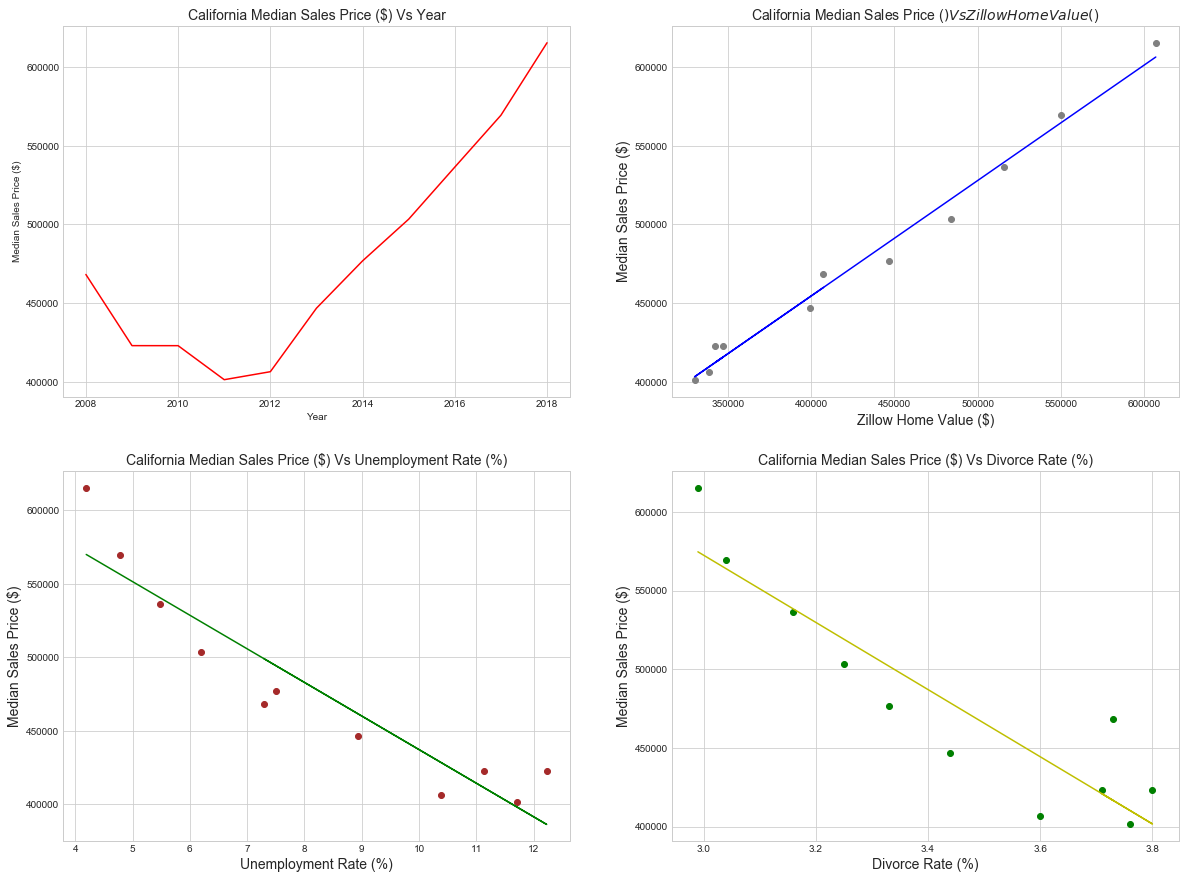

In [86]:
def showStatedata(data):
    # Transpose data
    x = massive_data.T
    state = str(data).upper()
    ak = x[state]
    i = 0
    vim = list(range(9))
    for x in vim:
        vim[x] = ak.iloc[i:i+11]
        i += 11
    state_keys = list(us_state_abbrev.keys())
    state_values = list(us_state_abbrev.values())
    name_state = state_keys[state_values.index(state)]
    columns = ["MSR","ZHVI","NS","FR","Divorce Rate","Unemployment Rate","Student Loan","Total Loan", "Median Income"]
    gather_concat = list(range(9))
    year = pd.DataFrame({"Year":[2008, 2009, 2010, 2011,
                                2012,2013,2014,2015,2016,2017,2018]})
    for i in gather_concat:
        gather_concat[i] = pd.DataFrame({columns[i]:vim[i]}).reset_index()[columns[i]]

    state_df = pd.concat(
                [year,gather_concat[0],gather_concat[1],gather_concat[2],
                 gather_concat[3],gather_concat[4],gather_concat[5],
                 gather_concat[6],gather_concat[7],gather_concat[8]], 
                 axis=1, sort=False
    ).set_index("Year")
    #Fill NA by average, change name of columns
    state_df.fillna(state_df.mean(), inplace=True)
    state_df = state_df.rename(columns={
                    "ZHVI":"Zillow Home Value ($)",
                    "MSR":"Median Sales Price ($)",
                    "NS":"Number of Sales",
                    "FR":"Foreclosure Resales (%)",
                    "Divorce Rate": "Divorce Rate (%)",
                    "Unemployment Rate": "Unemployment Rate (%)",
                    "Student Loan": "Student Loan ($)",
                    "Total Loan": "Total Loan ($)",
                    "Median Income": "Median Income ($)"
                })
    #print(state_df.corr())
    # Avoid duplicate and self correlations and proper sorting
    cor = state_df.corr()["Median Sales Price ($)"][:].abs().sort_values(ascending=False)[1:5]
    corr = pd.DataFrame(cor).index
    print(f"{name_state}'s Strongest Pearson Correlation Factors")
    print("---------------------------------------------------")
    print(cor)
    
    # First plot
    plt.figure(figsize=(20,15))
    plt.subplot(2, 2, 1)
    corr_df = state_df[corr]
    y_values = state_df["Median Sales Price ($)"]
    plt.plot(corr_df.index, y_values, color = "r")
    plt.title(f'{name_state} {y_values.name} Vs {corr_df.index.name}',fontsize=14)
    plt.xlabel(f'{corr_df.index.name}')
    plt.ylabel(f'{y_values.name}')
    plt.grid(True)
    
    
    # Second Plot
    # Plot scatter plot
    plt.subplot(2, 2, 2)
    x_values = corr_df.iloc[:,0]
    plt.scatter(x_values, y_values, color='grey')
    plt.title(f'{name_state} {y_values.name} Vs {x_values.name}',fontsize=14)
    # Run linear regression
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    # Plot regression line
    plt.plot(x_values,regress_values,"b-")
    #plt.annotate(line_eq,(x_values.max()*0.6,y_values.max()*0.93),fontsize=15,color="red")
    # Label plot
    plt.xlabel(f'{x_values.name}', fontsize=14)
    plt.ylabel(f'{y_values.name}', fontsize=14)
    # Show plot
    plt.grid(True)
    
    
    # Third Plot
    # Plot scatter plot
    plt.subplot(2, 2, 3)
    x_values = corr_df.iloc[:,1]
    plt.scatter(x_values, y_values, color='brown')
    plt.title(f'{name_state} {state_df.columns.values[0]} Vs {x_values.name}',fontsize=14)
    # Run linear regression
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    # Plot regression line
    plt.plot(x_values,regress_values,"g-")
    #plt.annotate(line_eq,(x_values.max()*0.6,y_values.max()*0.93),fontsize=15,color="black")
    # Label plot
    plt.xlabel(f'{x_values.name}', fontsize=14)
    plt.ylabel(f'{state_df.columns.values[0]}', fontsize=14)
    # Show plot
    plt.grid(True)
    
    
    # Fourth Plot
    # Plot scatter plot
    plt.subplot(2, 2, 4)
    x_values = corr_df.iloc[:,2]
    plt.scatter(x_values, y_values, color='green')
    plt.title(f'{name_state} {y_values.name} Vs {x_values.name}',fontsize=14)
    # Run linear regression
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    # Plot regression line
    plt.plot(x_values,regress_values,"y-")
    #plt.annotate(line_eq,(x_values.max()*0.85,y_values.max()*0.92),fontsize=15,color="red")
    # Label plot
    plt.xlabel(f'{x_values.name}', fontsize=14)
    plt.ylabel(f'{state_df.columns.values[0]}', fontsize=14)
    # Show plot
    plt.grid(True)
    return

showStatedata("CA")

In [87]:
def predictmsr(data):
    # Transpose data
    x = massive_data.T
    state = str(data).upper()
    ak = x[state]
    i = 0
    vim = list(range(9))
    for x in vim:
        vim[x] = ak.iloc[i:i+11]
        i += 11
    state_keys = list(us_state_abbrev.keys())
    state_values = list(us_state_abbrev.values())
    name_state = state_keys[state_values.index(state)]
    columns = ["MSR","ZHVI","NS","FR","Divorce Rate","Unemployment Rate","Student Loan","Total Loan", "Median Income"]
    gather_concat = list(range(9))
    year = pd.DataFrame({"Year":[2008, 2009, 2010, 2011,
                                2012,2013,2014,2015,2016,2017,2018]})
    for i in gather_concat:
        gather_concat[i] = pd.DataFrame({columns[i]:vim[i]}).reset_index()[columns[i]]

    state_df = pd.concat(
                [year,gather_concat[0],gather_concat[1],gather_concat[2],
                 gather_concat[3],gather_concat[4],gather_concat[5],
                 gather_concat[6],gather_concat[7],gather_concat[8]], 
                 axis=1, sort=False
    ).set_index("Year")

    #Fill NA by average, change name of columns
    state_df.fillna(state_df.mean(), inplace=True)
    state_df = state_df.rename(columns={
                    "ZHVI":"Zillow Home Value ($)",
                    "MSR":"Median Sales Price ($)",
                    "NS":"Number of Sales",
                    "FR":"Foreclosure Resales (%)",
                    "Divorce Rate": "Divorce Rate (%)",
                    "Unemployment Rate": "Unemployment Rate (%)",
                    "Student Loan": "Student Loan ($)",
                    "Total Loan": "Total Loan ($)",
                    "Median Income": "Median Income ($)"
                })
    #print(state_df.corr())
    # Avoid duplicate and self correlations and proper sorting
    cor = state_df.corr()["Median Sales Price ($)"][:].abs().sort_values(ascending=False)[1:5]
    corr = pd.DataFrame(cor).index
    corr_df = state_df[corr]
    print(f"RUNNING MULTIPLE REGRESSION ON {name_state}")
    print("--------------------------------------------------------")    
    ## Convert to floats and store x and y values
    X = pd.DataFrame({corr_df.index.name:corr_df.index, 
                      corr_df.iloc[:,0].name:corr_df.iloc[:,0], 
                      corr_df.iloc[:,1].name:corr_df.iloc[:,1]})
    
    Y = state_df["Median Sales Price ($)"]
    
    # with sklearn
    regr = linear_model.LinearRegression()
    regr.fit(X, Y)

    print('Intercept: \n', regr.intercept_)
    print('Coefficients: \n', regr.coef_)

    # New_Interest_Rate label and input box
    first =float(input(f'Type {X.iloc[:,0].name}: '))

    # New_Unemployment_Rate label and input box
    second =float(input(f'Type {X.iloc[:,1].name}: '))
   
    # New_Interest_Rate label and input box
    third = float(input(f'Type {X.iloc[:,2].name}: '))
    
    regr = round(int(regr.predict([[first ,second, third]])),2)
    print(f'Predicted {name_state} Median Sales Price: ${regr:,}')
    return 

predictmsr("ca")

RUNNING MULTIPLE REGRESSION ON California
--------------------------------------------------------
Intercept: 
 7985258.422143873
Coefficients: 
 [-3.97020803e+03  1.01582282e+00  5.57272009e+03]
Type Year: 2019
Type Zillow Home Value ($): 626331
Type Unemployment Rate (%): 4.3
Predicted California Median Sales Price: $629,612
